## Importar Dataset

In [ ]:
import os
import ast
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive/')
# method in Python used to change the current working directory to the specified path.
path = "/content/drive/MyDrive/Artigos_IC/"
os.chdir(path)
import shutil
shutil.copy('/content/drive/MyDrive/Artigos_IC/out_clean.csv', '/content/')

Mounted at /content/drive


'/content/out_clean.csv'

## Importanto bibliotecas para o Deep Learning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, multilabel_confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras import regularizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf


In [ ]:
df = pd.read_csv('/content/out_clean.csv', index_col=0)
df.columns=df.columns.str.replace(' ','_')
# Ensure that the `smell` column is interpreted as a string
df['agreement_experts_has_smell_name'] = df['agreement_experts_has_smell_name'].astype(str)

smell = df['agreement_experts_has_smell_name']

In [ ]:
df = df.drop('smell',axis=1)
df = df.drop('agreement_experts_has_smell',axis=1)
df = df.drop('severity',axis=1)
df = df.drop('type',axis=1)
df = df.drop('featureenvy_label',axis=1)
df = df.drop('blob_label',axis=1)
df = df.drop('dataclass_label',axis=1)
df = df.drop('longmethod_label',axis=1)

## start variables

In [ ]:
# Step 2: Separate Features (X) and Labels (y)
# Assuming 'longmethod', 'feature_envy', 'dataclass', and 'blob' are the label columns.
X = df.drop('agreement_experts_has_smell_name', axis=1)
y = smell
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

num_classes = len(one_hot_encoder.categories_)
# Step 3: Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



#  GRU,CNN, LSTM e MLP

In [ ]:
# Step 4: Scale the Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Reshape data for CNN and LSTM (if needed)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Step 5a: MLP Model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')  # Sigmoid for multi-label classification
])
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
mlp_history = mlp_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 5b: CNN Model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 5c: LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5902 - loss: 0.4773 - val_accuracy: 0.7290 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7339 - loss: 0.3114 - val_accuracy: 0.7309 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7386 - loss: 0.3000 - val_accuracy: 0.7341 - val_loss: 0.2852 - learning_rate: 0.0010
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7374 - loss: 0.2948 - val_accuracy: 0.7309 - val_loss: 0.2833 - learning_rate: 0.0010
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7500 - loss: 0.2843 - val_accuracy: 0.7327 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7471 - loss: 0.2859 - val_accuracy: 0.7346 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7487 - loss: 0.2779

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6445 - loss: 0.4909 - val_accuracy: 0.6762 - val_loss: 0.3491 - learning_rate: 0.0010
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6963 - loss: 0.3416 - val_accuracy: 0.6832 - val_loss: 0.3353 - learning_rate: 0.0010
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6930 - loss: 0.3380 - val_accuracy: 0.6823 - val_loss: 0.3322 - learning_rate: 0.0010
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7003 - loss: 0.3279 - val_accuracy: 0.6864 - val_loss: 0.3325 - learning_rate: 0.0010
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6990 - loss: 0.3283 - val_accuracy: 0.6841 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6982 - loss: 0.3283 - val_accuracy: 0.6864 - val_loss: 0.3298 - learning_rate: 0.0010
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7032 - loss: 0.3259 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.6380 - loss: 0.4471 - val_accuracy: 0.6758 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.6954 - loss: 0.3413 - val_accuracy: 0.6925 - val_loss: 0.3344 - learning_rate: 0.0010
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.7194 - loss: 0.3196 - val_accuracy: 0.6948 - val_loss: 0.3270 - learning_rate: 0.0010
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.7133 - loss: 0.3214 - val_accuracy: 0.6948 - val_loss: 0.3233 - learning_rate: 0.0010
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.7180 - loss: 0.3161 - val_accuracy: 0.6971 - val_loss: 0.3165 - learning_rate: 0.0010
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.7119 - loss: 0.3197 - val_accuracy: 0.7059 - val_loss: 0.3125 - learning_rate: 0.0010
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7194 - loss: 0.3106

In [ ]:
# Resize data to 3D
X_train_gru = np.expand_dims(X_train, axis=1)  # (batch_size, time_steps=1, feature_dim=num_features)
X_test_gru = np.expand_dims(X_test, axis=1)

# Build the GRU model
model_gru = Sequential([
    Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2])),  # (time_steps, feature_dim)
    GRU(128, activation='relu', return_sequences=False),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')  # Ajustado para multi-label classification
])

# Compile model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training model
history_gru = model_gru.fit(X_train_gru, y_train, epochs=10, batch_size=4, verbose=1)

Epoch 1/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7116 - loss: 0.3262
Epoch 2/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7384 - loss: 0.2785
Epoch 3/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7457 - loss: 0.2700
Epoch 4/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7576 - loss: 0.2594
Epoch 5/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7577 - loss: 0.2580
Epoch 6/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7648 - loss: 0.2490
Epoch 7/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7690 - loss: 0.2466
Epoch 8/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7683 - loss: 0.2429
Epoch 9/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.7746 - loss: 0.2404
Epoch 10/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7758 - loss: 0.2362


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model: MLP
Classification Report:
              precision    recall  f1-score   support

        blob       0.89      0.23      0.36       280
   dataclass       0.84      0.24      0.37       246
 featureenvy       0.68      0.10      0.17       152
  longmethod       0.89      0.14      0.24       115
        none       0.80      0.95      0.87      1905

   micro avg       0.80      0.73      0.76      2698
   macro avg       0.82      0.33      0.40      2698
weighted avg       0.81      0.73      0.70      2698
 samples avg       0.73      0.73      0.73      2698

Acurácia
0.729058561897702


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


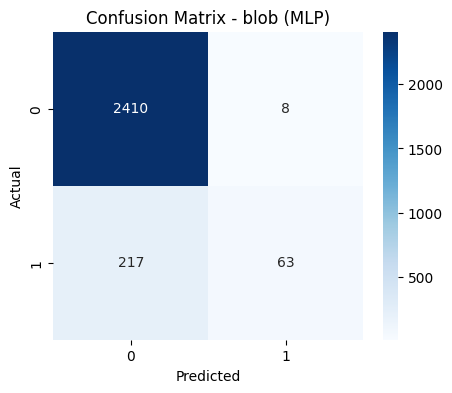

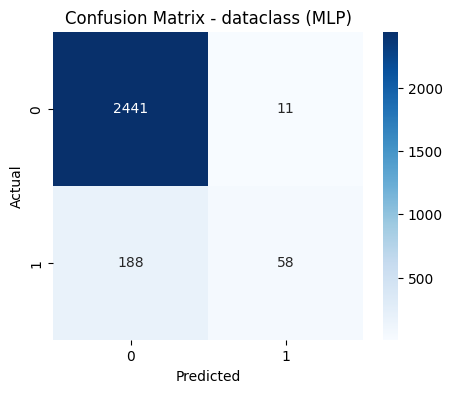

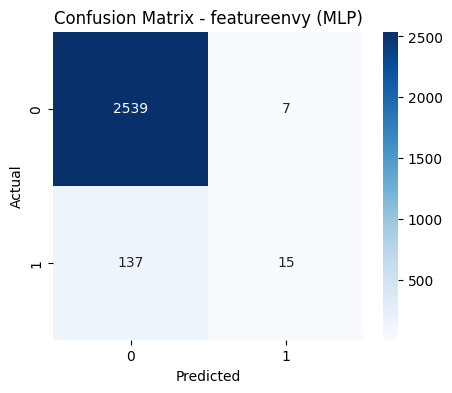

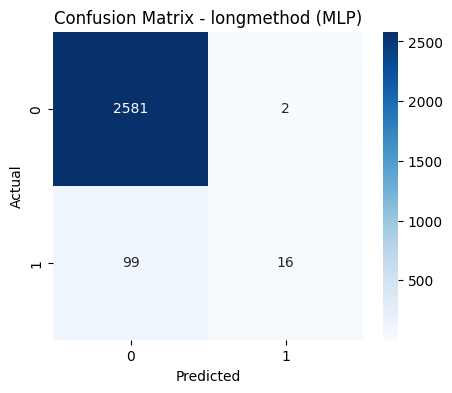

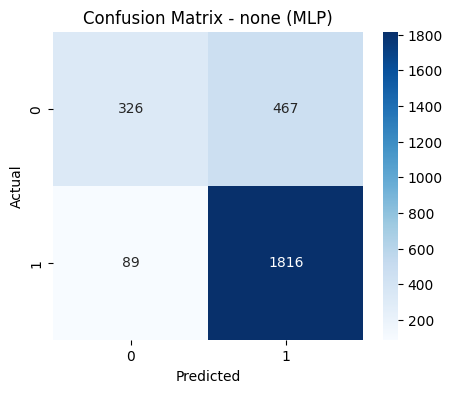

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model: CNN
Classification Report:
              precision    recall  f1-score   support

        blob       0.71      0.05      0.10       280
   dataclass       0.00      0.00      0.00       246
 featureenvy       0.00      0.00      0.00       152
  longmethod       0.00      0.00      0.00       115
        none       0.75      0.96      0.84      1905

   micro avg       0.75      0.68      0.72      2698
   macro avg       0.29      0.20      0.19      2698
weighted avg       0.61      0.68      0.61      2698
 samples avg       0.68      0.68      0.68      2698

Acurácia
0.6834692364714603


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


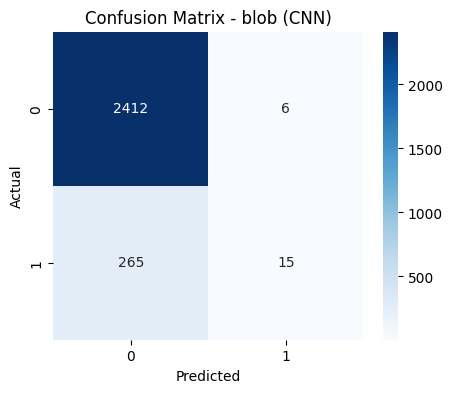

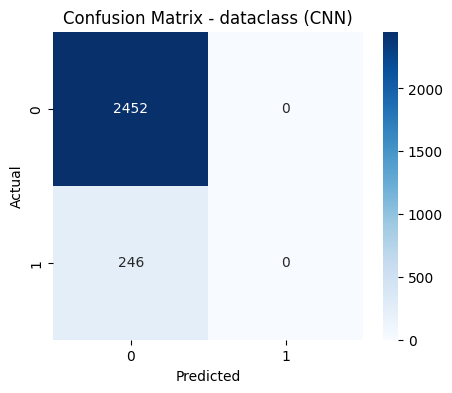

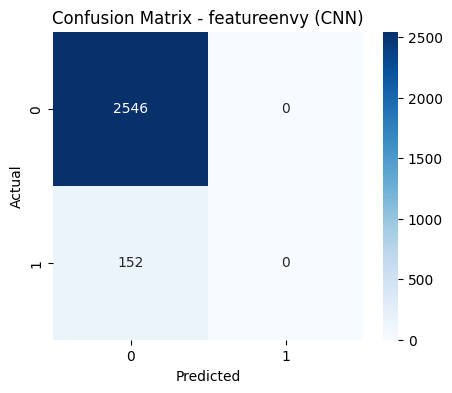

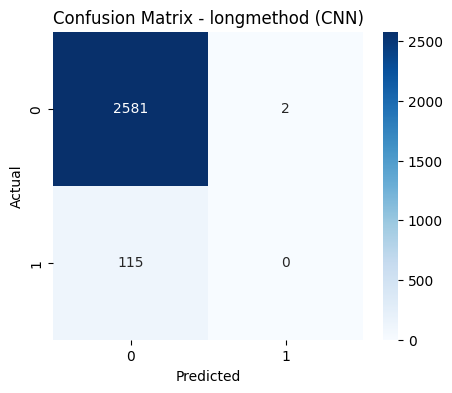

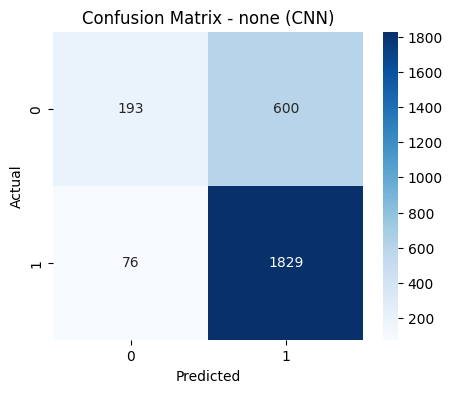

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model: GRU
Classification Report:
              precision    recall  f1-score   support

        blob       0.74      0.35      0.48       280
   dataclass       0.73      0.28      0.41       246
 featureenvy       0.61      0.12      0.21       152
  longmethod       0.81      0.15      0.25       115
        none       0.81      0.94      0.87      1905

   micro avg       0.80      0.74      0.77      2698
   macro avg       0.74      0.37      0.44      2698
weighted avg       0.78      0.74      0.72      2698
 samples avg       0.73      0.74      0.74      2698

Acurácia
0.7338769458858414


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


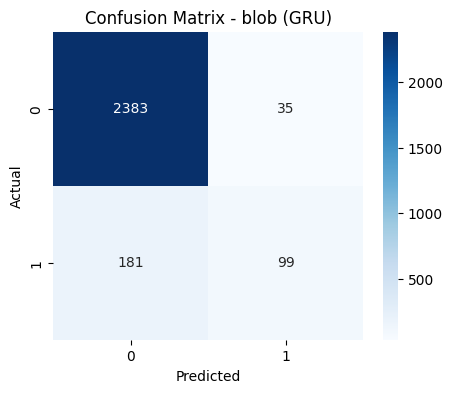

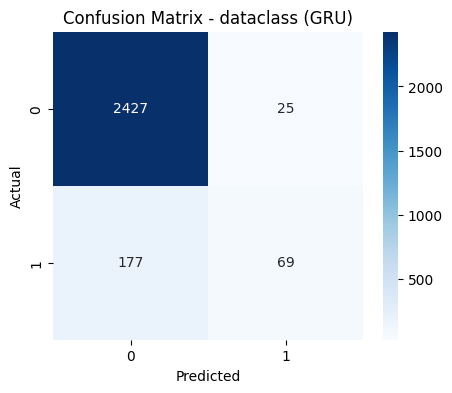

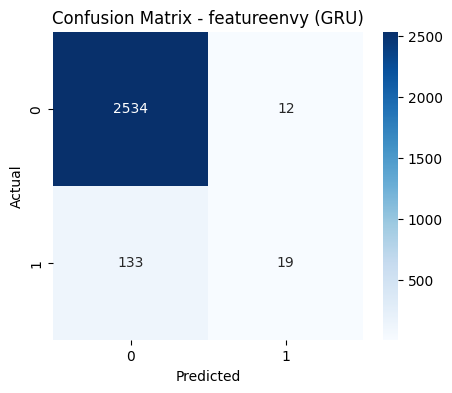

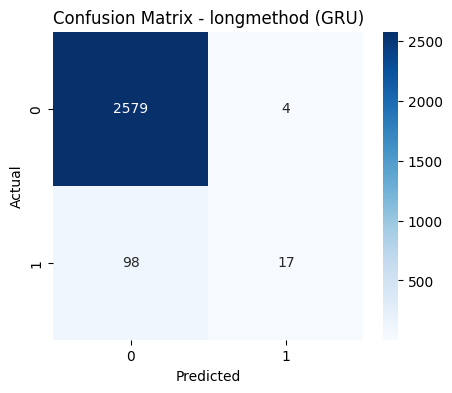

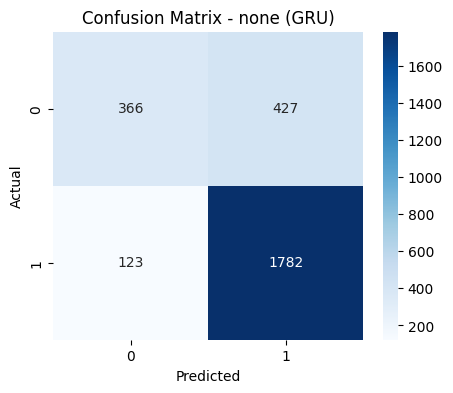

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

Model: LSTM
Classification Report:
              precision    recall  f1-score   support

        blob       0.69      0.33      0.45       280
   dataclass       0.92      0.19      0.32       246
 featureenvy       1.00      0.05      0.09       152
  longmethod       1.00      0.13      0.23       115
        none       0.79      0.95      0.86      1905

   micro avg       0.79      0.73      0.76      2698
   macro avg       0.88      0.33      0.39      2698
weighted avg       0.81      0.73      0.70      2698
 samples avg       0.73      0.73      0.73      2698

Acurácia
0.7312824314306894


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


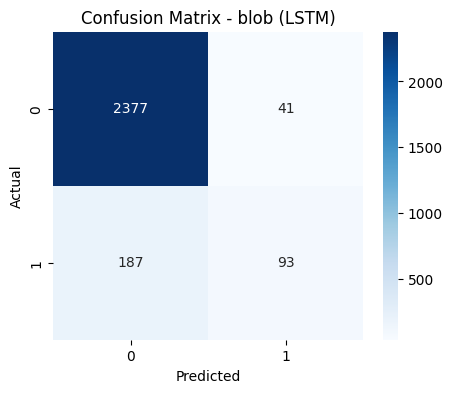

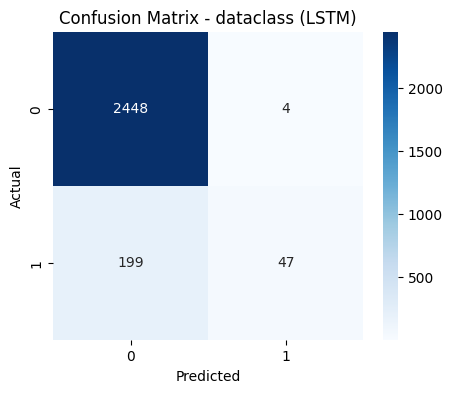

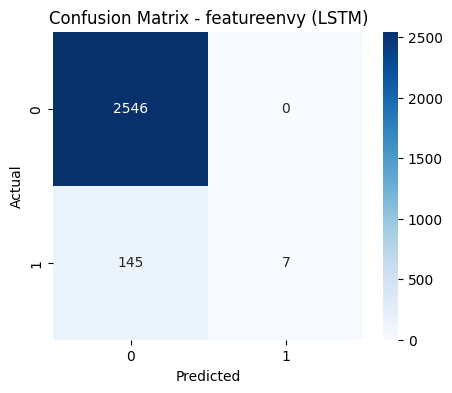

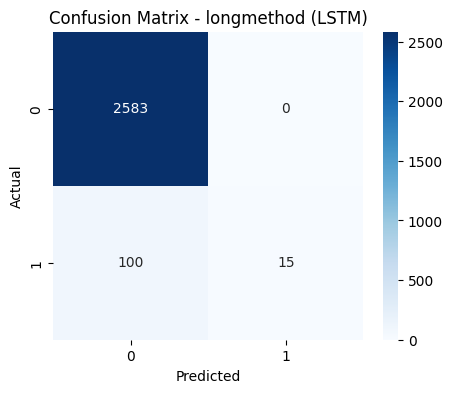

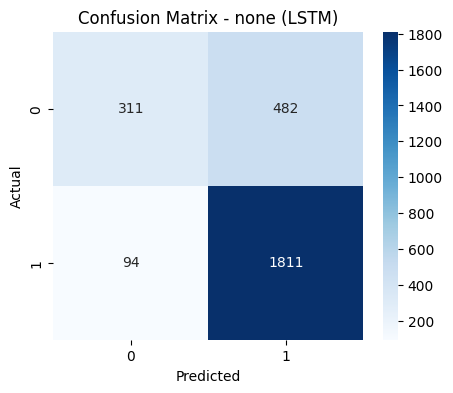

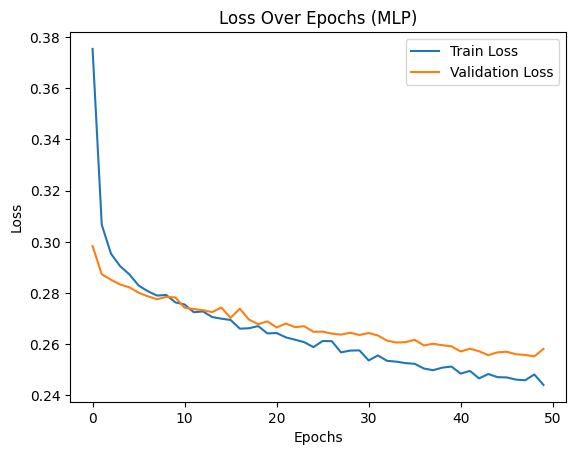

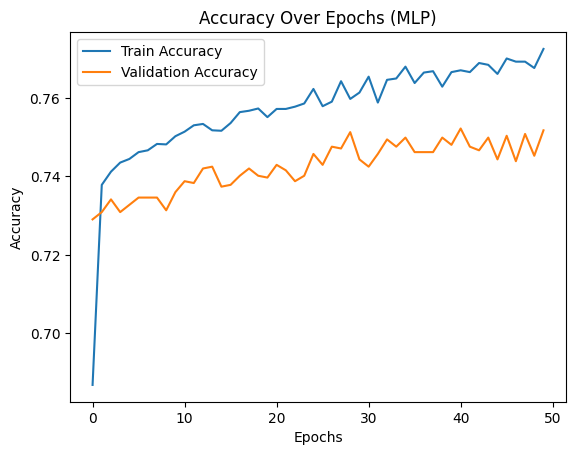

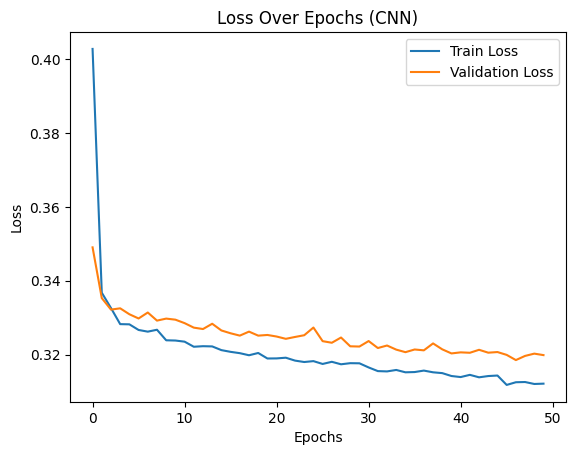

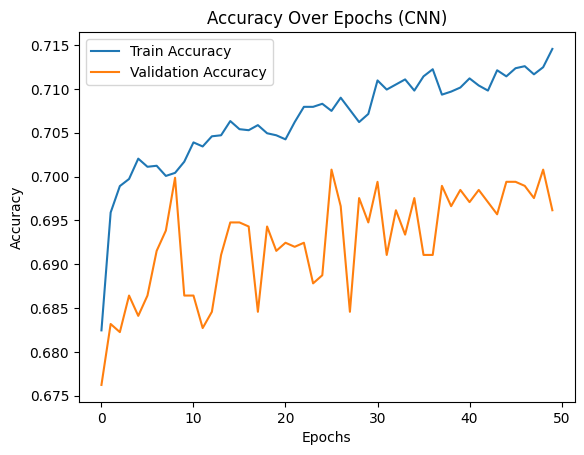

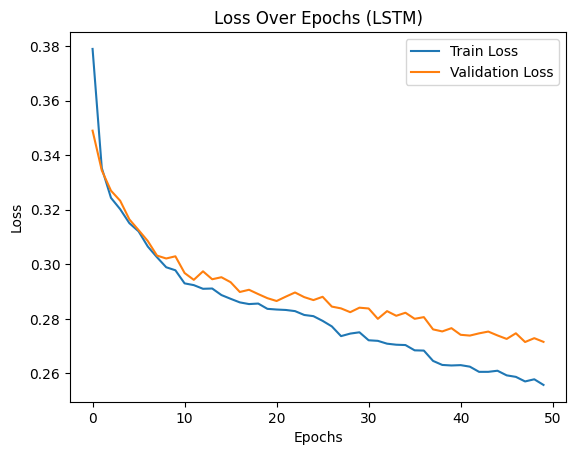

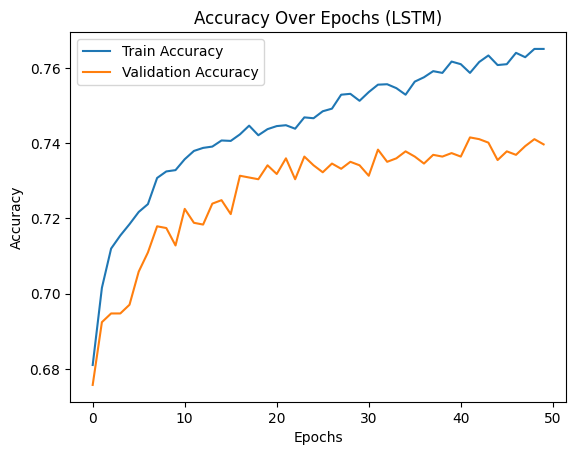

KeyError: 'val_loss'

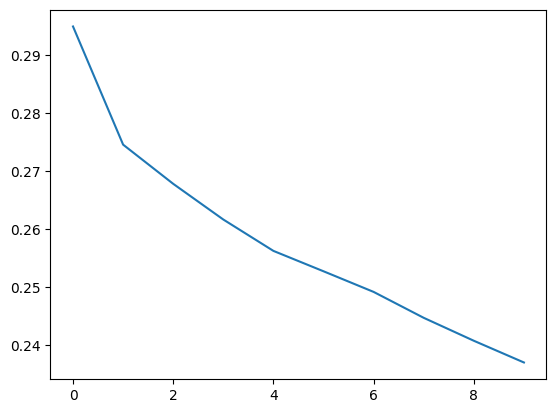

In [ ]:
# Step 6: Evaluate Models
def evaluate_model(model, X_test, y_test, model_name):
    if len(X_test.shape) == 2:  # For MLP
        predictions = model.predict(X_test)
    elif model_name=='CNN' or model_name=='LSTM':  # For CNN and LSTM
        predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    else:
        predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    print(f"\nModel: {model_name}")
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=one_hot_encoder.categories_[0]))
    print("Acurácia")
    print(accuracy_score(y_test, predictions))
    conf_matrix = multilabel_confusion_matrix(y_test, predictions)
    for i, label in enumerate(one_hot_encoder.categories_[0]):
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {label} ({model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Evaluate all models
evaluate_model(mlp_model, X_test, y_test, "MLP")
evaluate_model(cnn_model, X_test_cnn, y_test, "CNN")
evaluate_model(model_gru, X_test_gru, y_test, "GRU")
evaluate_model(lstm_model, X_test_cnn, y_test, "LSTM")
#evaluate_model(history_capsnet, X_test, y_test, "CapsuleNetworks")

# Step 7: Plot Training History
def plot_history(history, model_name):
    plt.plot(history.history['loss'], label='Train Loss')
    if model_name!="GRU":
      plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'Loss Over Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if model_name!="GRU":
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'Accuracy Over Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Plot histories
plot_history(mlp_history, "MLP")
plot_history(cnn_history, "CNN")
plot_history(lstm_history, "LSTM")
plot_history(history_gru, "GRU")

# Auto Keras

In [ ]:
!pip3 install autokeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.2 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf
import autokeras as ak

X = df.drop("agreement_experts_has_smell_name", axis=1)
y = smell



# Coding the labels for numerical values
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize numerical characteristics
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Configuring AutoModel
input_node = ak.Input()
output_node =ak.ClassificationHead()
# Create model
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=15  # Define how many models will be tested
)

# Training model
clf.fit(x=X_train, y=y_train, epochs=20, validation_split=0.2, batch_size=8)

# Evaluate model
accuracy = clf.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy[1]:.4f}")

# Making predictions
y_pred = clf.predict(X_test).flatten()

Trial 15 Complete [00h 02m 41s]
val_loss: 0.7154724597930908

Best val_loss So Far: 0.7154724597930908
Total elapsed time: 00h 24m 36s
Epoch 1/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7275 - loss: 0.9485
Epoch 2/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7471 - loss: 0.8293
Epoch 3/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7513 - loss: 0.8066
Epoch 4/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7583 - loss: 0.7838
Epoch 5/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7625 - loss: 0.7586
Epoch 6/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7658 - loss: 0.7396
Epoch 7/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7673 - loss: 0.7240
Epoch 8/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7725 - loss: 0.7046
Epoch 9/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7782 - loss: 0.6896
Epoch 10/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.780

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 1 variables whereas the saved optimizer has 13 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7779 - loss: 0.6448
Acurácia no conjunto de teste: 0.7806
71/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 61))
  warnings.warn(msg)


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
y_pred = clf.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 10: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=one_hot_encoder.categories_[0]))

#tuner AutoModel
tuner = clf.tuner


best_trials = tuner.oracle.get_best_trials(num_trials=10)  # best top 10 models

for i, trial in enumerate(best_trials):
    print(f"\nModelo {i+1}:")
    print("Hiperparâmetros:")
    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")

    model = tuner.hypermodel.build(trial.hyperparameters)
    print("\nResumo do Modelo:")
    model.summary()


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:

              precision    recall  f1-score   support

        blob       0.66      0.46      0.54       280
   dataclass       0.66      0.39      0.49       246
 featureenvy       0.50      0.14      0.22       152
  longmethod       0.56      0.28      0.37       115
        none       0.81      0.96      0.88      1905

   micro avg       0.78      0.78      0.78      2698
   macro avg       0.64      0.45      0.50      2698
weighted avg       0.75      0.78      0.75      2698
 samples avg       0.78      0.78      0.78      2698


Modelo 1:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 256
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0.25
  optimizer: adam_weight_decay
  learning_rate: 0.001


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_1               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 2:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 256
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 256
  classification_head_1/dropout: 0.25
  optimizer: adam_weight_decay
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_2               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 3:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 256
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 256
  classification_head_1/dropout: 0.0
  optimizer: adam_weight_decay
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_3               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 4:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 128
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 256
  classification_head_1/dropout: 0.25
  optimizer: adam_weight_decay
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_4 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_4               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 5:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 256
  classification_head_1/dropout: 0.25
  optimizer: adam_weight_decay
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_5               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 6:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 256
  classification_head_1/dropout: 0.25
  optimizer: adam
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_6 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_6               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 7:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 256
  classification_head_1/dropout: 0.0
  optimizer: adam
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_7 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_7               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 8:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 32
  classification_head_1/dropout: 0.25
  optimizer: adam
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_8 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_8               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 9:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 16
  classification_head_1/dropout: 0.25
  optimizer: adam_weight_decay
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_9 (Cast)                   │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_9               │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 10:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 32
  classification_head_1/dropout: 0.25
  optimizer: adam_weight_decay
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_10 (Cast)                  │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_10              │ (None, 61)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,205 (12.52 KB)

 Non-trainable params: 0 (0.00 B)